# Data Analytics Project - Models

# Pair 2 - BEML ARIMA Model

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from fastai.tabular.core import add_datepart
from pmdarima.arima import auto_arima
from sklearn import metrics

/home/varun487/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


---

# 2. Get Pair 2 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair2/Pair2_orders.csv')
orders_df.head()

,Date,BEML_Close,ESCORTS_Close,Spread,zscore,Orders
0,2018-08-06,909.099976,880.049988,29.049988,1.821236,SHORT
1,2018-08-07,868.599976,873.700012,-5.100037,0.672698,FLAT
2,2018-08-08,825.150024,876.500000,-51.349976,-0.882785,GET_OUT_OF_POSITION
3,2018-08-09,810.150024,878.750000,-68.599976,-1.462939,FLAT
4,2018-08-10,807.750000,865.250000,-57.500000,-1.089624,FLAT


In [3]:
orders_df.tail()

,Date,BEML_Close,ESCORTS_Close,Spread,zscore,Orders
54,2018-10-29,561.150024,591.450012,-30.299988,-0.174830,FLAT
55,2018-10-30,585.650024,603.950012,-18.299988,0.228756,FLAT
56,2018-10-31,587.250000,627.000000,-39.750000,-0.492654,FLAT
57,2018-11-01,632.400024,674.450012,-42.049988,-0.570007,FLAT
58,2018-11-02,688.900024,676.000000,12.900024,1.278078,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

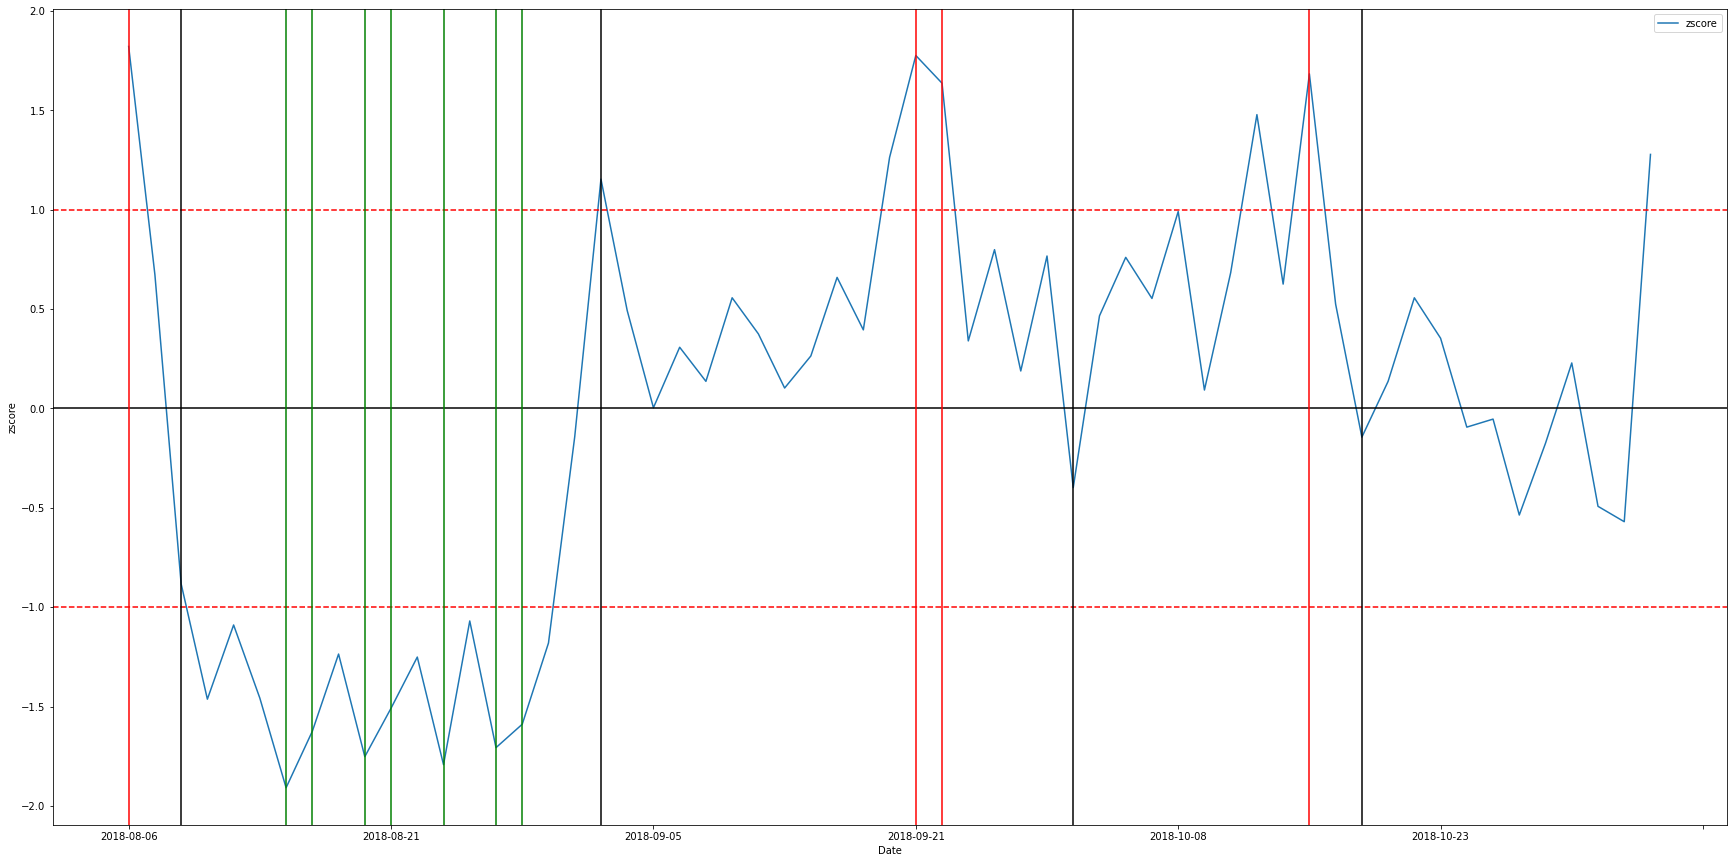

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

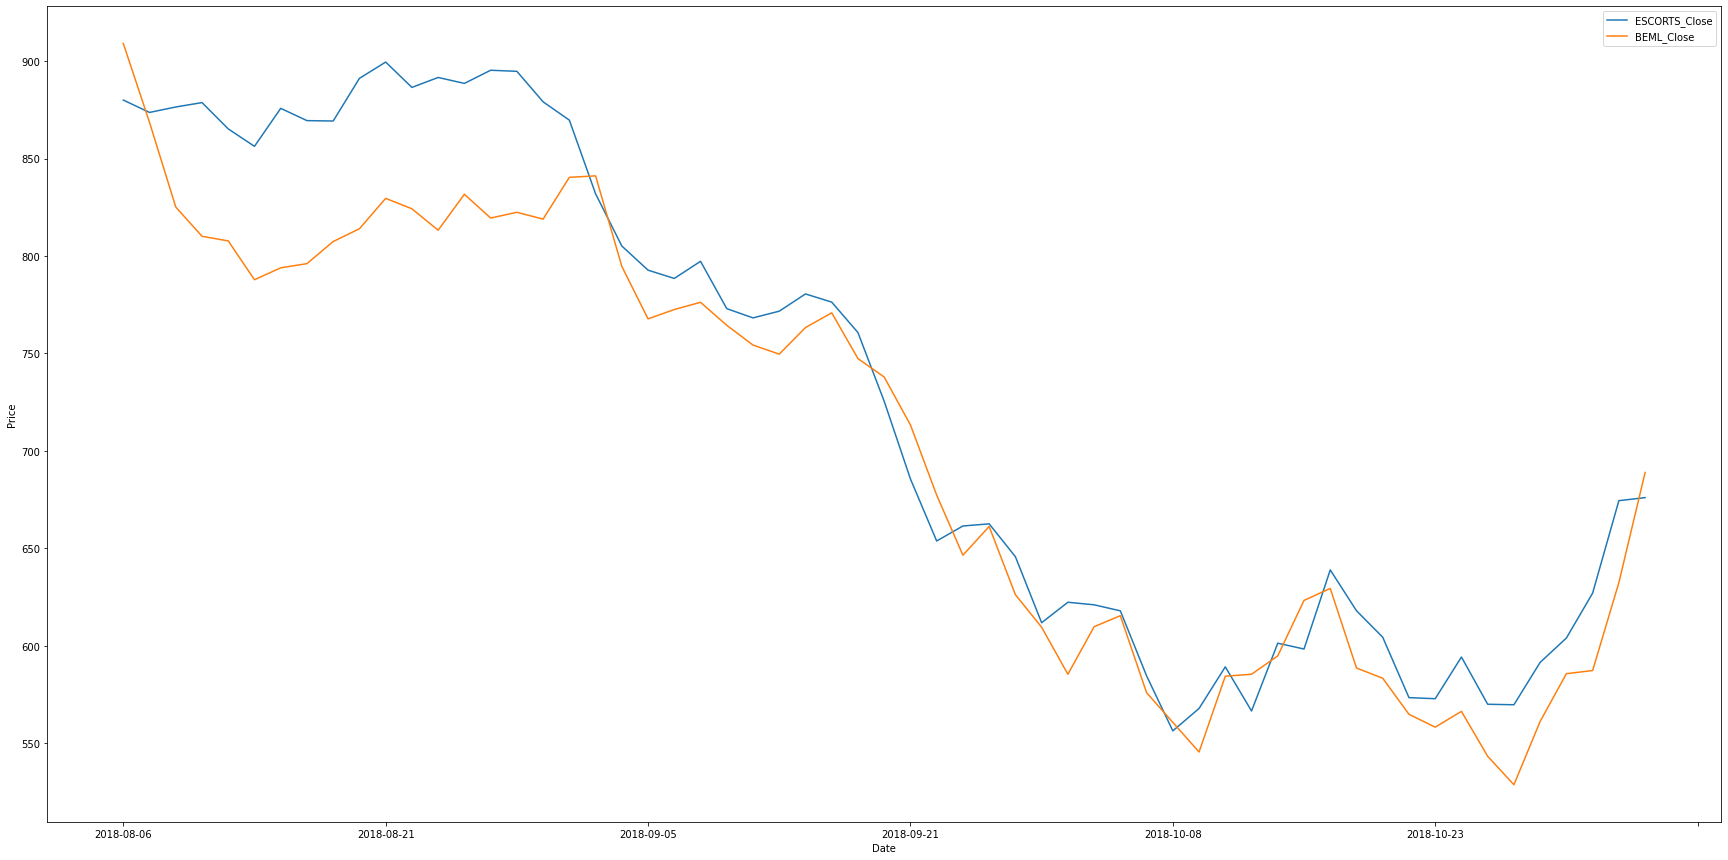

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['ESCORTS_Close', 'BEML_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. BEML Linear Regression Model

## 3.1. Get the Complete BEML dataset

In [6]:
beml_df = pd.read_csv("../../Storage/Companies_with_names_exchange/BEMLNSE.csv")
beml_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,1006.500000,989.150024,1004.000000,996.299988,150354.0,968.879944,BEML,NSE
1,2017-01-03,1015.950012,996.200012,1002.799988,1009.299988,285489.0,981.522095,BEML,NSE
2,2017-01-04,1023.000000,1002.750000,1013.799988,1005.799988,202005.0,978.118469,BEML,NSE
3,2017-01-05,1017.500000,993.599976,1006.400024,1001.599976,150463.0,974.033997,BEML,NSE
4,2017-01-06,1009.000000,987.900024,998.500000,993.549988,161214.0,966.205627,BEML,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get BEML training data

### 3.2.1 Get complete beml dataset

In [7]:
beml_df = beml_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
beml_df.head()

,Date,Close
0,2017-01-02,996.299988
1,2017-01-03,1009.299988
2,2017-01-04,1005.799988
3,2017-01-05,1001.599976
4,2017-01-06,993.549988


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
beml_df_train = beml_df[beml_df['Date'] >= '2017-09-03']
beml_df_train.head()

,Date,Close
166,2017-09-04,1855.599976
167,2017-09-05,1851.000000
168,2017-09-06,1836.150024
169,2017-09-07,1882.949951
170,2017-09-08,1855.949951


In [9]:
beml_df_train = beml_df_train[beml_df_train['Date'] <= '2018-09-04']
beml_df_train.tail()

,Date,Close
412,2018-08-29,822.450012
413,2018-08-30,818.950012
414,2018-08-31,840.400024
415,2018-09-03,841.150024
416,2018-09-04,794.700012


### 3.2.3 Get the training data and labels

In [10]:
beml_train = beml_df_train.copy()
beml_train

,Date,Close
166,2017-09-04,1855.599976
167,2017-09-05,1851.000000
168,2017-09-06,1836.150024
169,2017-09-07,1882.949951
170,2017-09-08,1855.949951
...,...,...
412,2018-08-29,822.450012
413,2018-08-30,818.950012
414,2018-08-31,840.400024
415,2018-09-03,841.150024


In [11]:
beml_train = beml_train.reset_index(drop=True)
beml_train = beml_train['Close']
beml_train

0      1855.599976
1      1851.000000
2      1836.150024
3      1882.949951
4      1855.949951
          ...     
246     822.450012
247     818.950012
248     840.400024
249     841.150024
250     794.700012
Name: Close, Length: 251, dtype: float64

In [12]:
len(beml_train)

251

## 3.3. Get BEML Test Data

In [13]:
beml_test_df = orders_df.copy()
beml_test_df = beml_df[(beml_df['Date'] >= '2018-09-04') & (beml_df['Date'] <= '2018-12-03')].copy()
beml_test_df.head()

,Date,Close
416,2018-09-04,794.700012
417,2018-09-05,767.750000
418,2018-09-06,772.549988
419,2018-09-07,776.250000
420,2018-09-10,764.450012


In [14]:
beml_test_df.tail()

,Date,Close
470,2018-11-27,758.849976
471,2018-11-28,775.200012
472,2018-11-29,764.950012
473,2018-11-30,752.849976
474,2018-12-03,747.599976


In [15]:
beml_test = beml_test_df.copy()
beml_test.reset_index(drop=True, inplace=True)
beml_test.index += 251
beml_test.head()

,Date,Close
251,2018-09-04,794.700012
252,2018-09-05,767.750000
253,2018-09-06,772.549988
254,2018-09-07,776.250000
255,2018-09-10,764.450012


In [16]:
beml_test.tail()

,Date,Close
305,2018-11-27,758.849976
306,2018-11-28,775.200012
307,2018-11-29,764.950012
308,2018-11-30,752.849976
309,2018-12-03,747.599976


In [17]:
beml_test = beml_test['Close']

In [18]:
len(beml_test)

59

## 3.4 Create and Train BEML Model

In [19]:
model = auto_arima(beml_train, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(beml_train)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2466.729, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2426.173, Time=0.47 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.76 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2467.447, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2395.570, Time=1.34 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.08 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.31 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2394.269, Time=1.17 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=2425.107, Time=0.36 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=8.30 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.20 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2395.572, Time=1.86 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=2397.570, Time=2.68 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=2396.2

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

## 3.5. Get predictions

In [20]:
forecast = model.predict(n_periods=len(beml_test))
forecast = pd.DataFrame(forecast, index = beml_test.index, columns=['Prediction'])
forecast

,Prediction
251,793.382360
252,786.817999
253,801.045660
254,793.949767
255,784.870888
256,780.706759
257,766.809046
258,774.102287
259,767.933075
260,782.385302


In [21]:
predictions = forecast['Prediction']
print('Mean Absolute Error:', metrics.mean_absolute_error(beml_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(beml_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(beml_test, predictions)))

Mean Absolute Error: 98.92814879328428
Mean Squared Error: 16348.935902199917
Root Mean Squared Error: 127.86295750607334


## 3.6. Visualize the predicitons vs test data

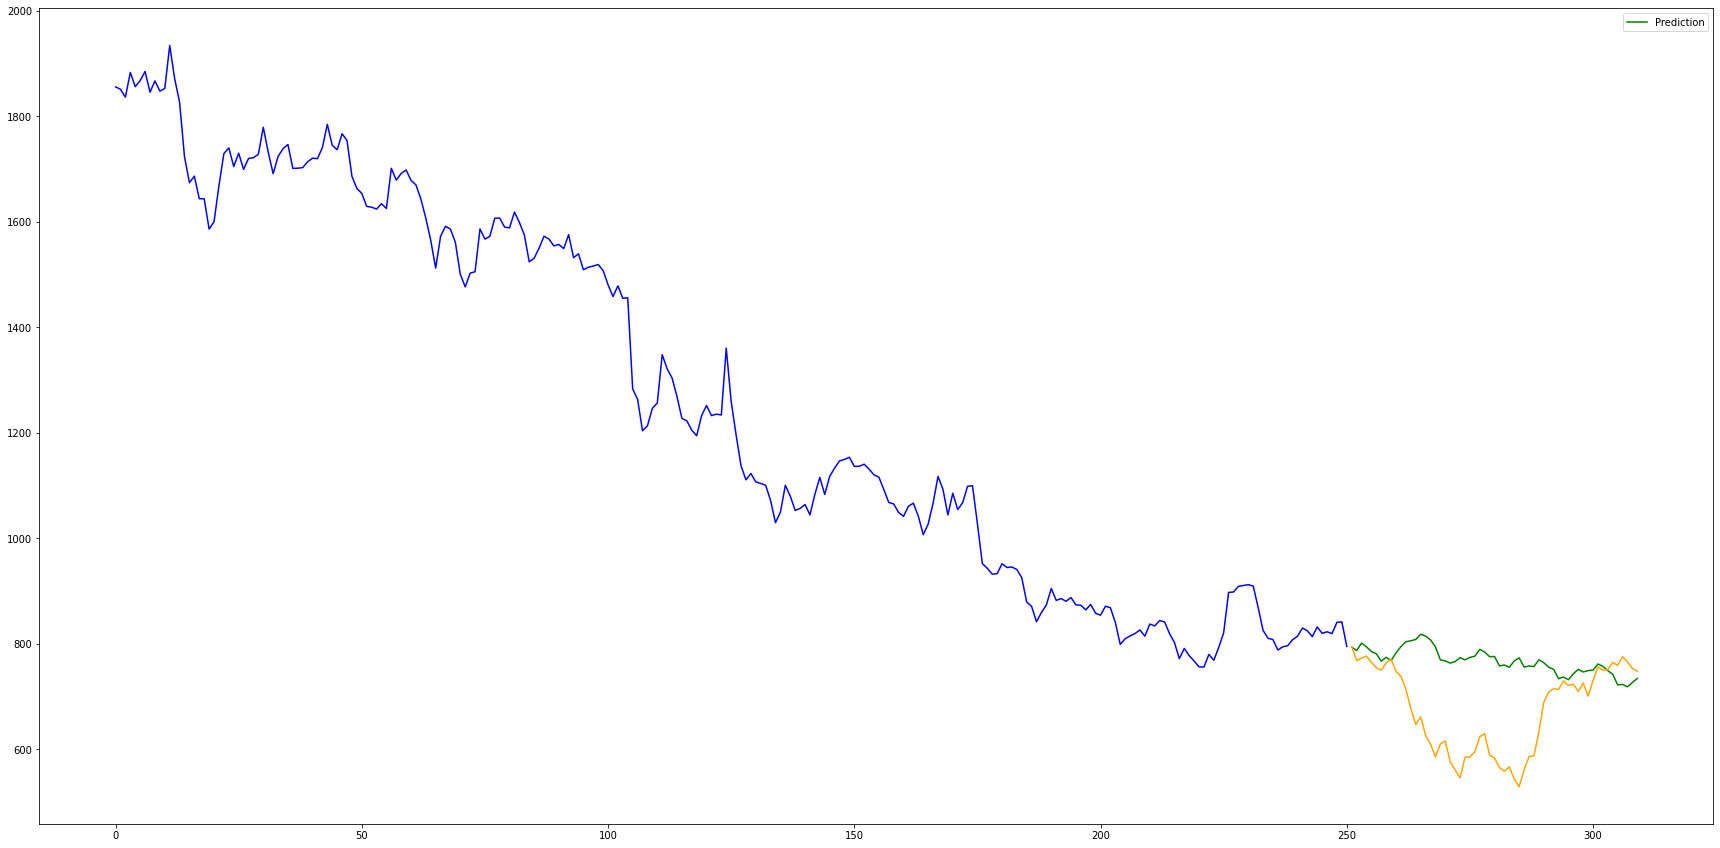

In [22]:
beml_model_plt = forecast.plot(y=['Prediction'], figsize=(30,15), c='green')
beml_model_plt.plot(beml_train, c='blue')
beml_model_plt.plot(beml_test, c='orange')

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results in a file

In [23]:
beml_predictions_df = pd.read_csv('Beml_predicitions.csv')
beml_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
0,2018-08-06,909.099976,762.413834,793.382360
1,2018-08-07,868.599976,755.794835,786.817999
2,2018-08-08,825.150024,749.175836,801.045660
3,2018-08-09,810.150024,742.556836,793.949767
4,2018-08-10,807.750000,747.687468,784.870888


In [24]:
forecast = forecast.reset_index()
forecast = forecast.drop(columns='index')
beml_predictions_df['ARIMA_Close'] = forecast['Prediction']
beml_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
0,2018-08-06,909.099976,762.413834,793.382360
1,2018-08-07,868.599976,755.794835,786.817999
2,2018-08-08,825.150024,749.175836,801.045660
3,2018-08-09,810.150024,742.556836,793.949767
4,2018-08-10,807.750000,747.687468,784.870888


In [25]:
beml_predictions_df.to_csv('Beml_predicitions.csv', index=False)